In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import random
from sklearn.preprocessing import LabelEncoder
import glob
import time
import pickle
import pandas as pd
from pathlib import Path
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from spektral.layers import GraphConv, GlobalAvgPool, EdgeConditionedConv
from spektral.utils import Batch, batch_iterator
from spektral.utils import label_to_one_hot, normalized_laplacian
from spektral.layers.ops import sp_matrix_to_sp_tensor
import graph
import networkx as nx
import scipy.sparse as sp
from spektral.datasets import mnist
from keras.layers import MaxPooling2D, Reshape
from spektral.layers import GraphConv, ChebConv
from spektral.utils import localpooling_filter
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utilities import generate_graph,create_graph


Bad key savefig.frameon in file C:\Program Files\Anaconda3\envs\gcn\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Program Files\Anaconda3\envs\gcn\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Program Files\Anaconda3\envs\gcn\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need t

In [2]:
train_path = 'train_trim'
# Parameters
user_reguralization_rate = 5e-4         
user_model_learning_rate = 0.03  
user_model_batch = 100    
epochs = 80    
print(train_path)

train_trim


In [3]:
# folder preprocessing 

def check_folder_path(path):   
    if not Path.is_dir(path):   
        raise ValueError("argument is not directory")   
       
    yield from filter(Path.is_dir, path.iterdir())


def check_depth(path, depth):
    if 0 > depth:
        raise ValueError("depth smaller 0")
    if 0 == depth:
        yield from check_folder_path(path)
    else:
        for folder in check_folder_path(path):
            yield from check_depth(folder, depth - 1)


def check_files(path):
    if not Path.is_dir(path):
        raise ValueError("argument is not a directory")
    yield from filter(Path.is_file, path.iterdir())


def sum_file_size(filepaths):
    return sum([filep.stat().st_size for filep in filepaths])


def convert_image_to_array(image_dir):
    try:
        image = cv.imread(image_dir)

        if image is not None:

            image1 = cv.resize(image, default_image_size)
            gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)

            return img_to_array(gray).flatten()
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def graph_convolution_one_layer_model(A, N=28 * 28, F=1,n_out=10,l2_reg=user_reguralization_rate,
                     learning_rate=user_model_learning_rate,
                     ):

    L = localpooling_filter(A)

    X_in = Input(shape=(N, F)) # N=nodes and F=features dimension

    A_in = Input(tensor=sp_matrix_to_sp_tensor(L))

    graph_conv = GraphConv(10,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])

    fc = Flatten()(graph_conv)
    output = Dense(n_out, activation='softmax')(fc)

    # Build model
    model = Model(inputs=[X_in, A_in], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def graph_convolution_network(A, N=28 * 28, F=1,
        n_out=10,
        l2_reg=user_reguralization_rate,
        learning_rate=user_model_learning_rate,
        ):
    
    L = localpooling_filter(A)
    X_in = Input(shape=(N, F))
    A_in = Input(tensor=sp_matrix_to_sp_tensor(L))

    graph_conv = GraphConv(32,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])
    graph_conv = GraphConv(32,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([graph_conv, A_in])

    rs = Reshape((28, 28, 32))(graph_conv)
    pooled = MaxPooling2D(pool_size=(2, 2))(rs)
    flatten = Flatten()(pooled)
    fc = Dense(512, activation='relu')(flatten)
    output = Dense(n_out, activation='softmax')(fc)
    # Build model
    model = Model(inputs=[X_in, A_in], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [4]:
image_list, label_list = [], []
train_labels = os.listdir(train_path)  # take training path labels
num_labels=len(train_labels)
print(num_labels)
train_labels.sort()  # sort the labels
print(train_labels)  # primt the lables
labels = []  # create label variables so as to decode text to number
total = 0  # initialize
tot_file = []  # initialize
count = 1  # start count to check number of images
i = 0
j = 0
k = 0
print(Path.cwd())  # gives the current path
for folder in check_depth(Path.cwd(), 1):
    # first loop will pick the first foldend then next folder
    files = list(check_files(folder))  # list all files in folder
    file = len(files)  # length of files
    tot_file.append(file)  # because we are running for all folder
    # we are appending all files in tot_file at the end we
    # shall get the list of number of files in the folder
    # we are doing this because every folder has different number of files
    # at the end when we are trainig all class of disease have to be
    # trained equally, hence find the least number of images in the folder
    # and then train accordingly
    total_size = sum_file_size(files)
    # total size of files
    count = count + 1  # check total number of files executed
    print(f'{folder}:filecount:{len(files)},total size:{total_size}')

tot_file.sort()  # sort files based on ascending order
num = int(tot_file[1])  # Index 0 is junkhence extract index 1

print('tOTAL FILE:', tot_file)
print(num)

images_per_class = num # consider number of images per class
# %%START WITH TRAINING
# for tr_name in range(0,2):
count = 0
default_image_size = tuple((28, 28))

for count in range(0, len(train_labels)):

    tr_name = count

    dir = train_path + '\\' + train_labels[tr_name]
    current_label = train_labels[tr_name]
    print("[STATUS] processed folder: {}".format(current_label))
    k = 1
    file_sub_folder = os.listdir(dir)
    for x in range(0, images_per_class):
        file = dir + '\\' + file_sub_folder[x]

        image_list.append(convert_image_to_array(file))
        label_list.append(current_label)
        i += 1
        k += 1
        count = count + 1
print("[STATUS] training labels{}".format(np.array(label_list).shape))
labelEncoder = LabelEncoder()
image_size = len(image_list)
image_labels = labelEncoder.fit_transform(label_list)

np_image_list = np.array(image_list, dtype=np.float32) / 225.0
print("[INFO] Spliting data to train, test")
X_train, X_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)
X_val = X_test
y_val = y_test

4
['angry', 'happy', 'sad', 'surprise']
f:\Python\EmotionGCN\Emotion_detection
f:\Python\EmotionGCN\Emotion_detection\.idea\inspectionProfiles:filecount:1,total size:174
f:\Python\EmotionGCN\Emotion_detection\gcn\conda-meta:filecount:61,total size:11459445
f:\Python\EmotionGCN\Emotion_detection\gcn\DLLs:filecount:34,total size:10595549
f:\Python\EmotionGCN\Emotion_detection\gcn\include:filecount:102,total size:656144
f:\Python\EmotionGCN\Emotion_detection\gcn\Lib:filecount:172,total size:4325196
f:\Python\EmotionGCN\Emotion_detection\gcn\Library:filecount:0,total size:0
f:\Python\EmotionGCN\Emotion_detection\gcn\libs:filecount:3,total size:512288
f:\Python\EmotionGCN\Emotion_detection\gcn\Scripts:filecount:83,total size:13221247
f:\Python\EmotionGCN\Emotion_detection\gcn\share:filecount:0,total size:0
f:\Python\EmotionGCN\Emotion_detection\gcn\sip:filecount:0,total size:0
f:\Python\EmotionGCN\Emotion_detection\gcn\tcl:filecount:6,total size:1600642
f:\Python\EmotionGCN\Emotion_detectio

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [13]:
gen_random_seed = 2000
os.environ['PYTHONHASHSEED']=str(gen_random_seed)
random.seed(gen_random_seed)
np.random.seed(gen_random_seed)
tf.compat.v1.random.set_random_seed(gen_random_seed)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


In [14]:
X_train, X_val, X_test = X_train[..., None], X_val[..., None], X_test[..., None]
N = X_train.shape[-2]      # Number of nodes in the graphs
F = X_train.shape[-1]      # Node features dimensionality
n_out = 10  # Dimension of the target
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(10256, 784, 1) (10256,)
(2564, 784, 1) (2564,)
(2564, 784, 1) (2564,)


3198 > 3136 edges
Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


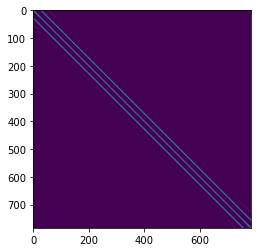

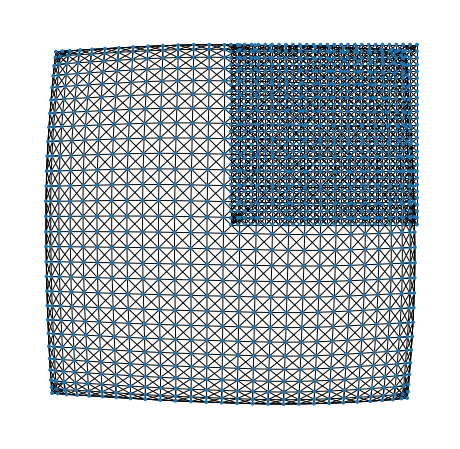

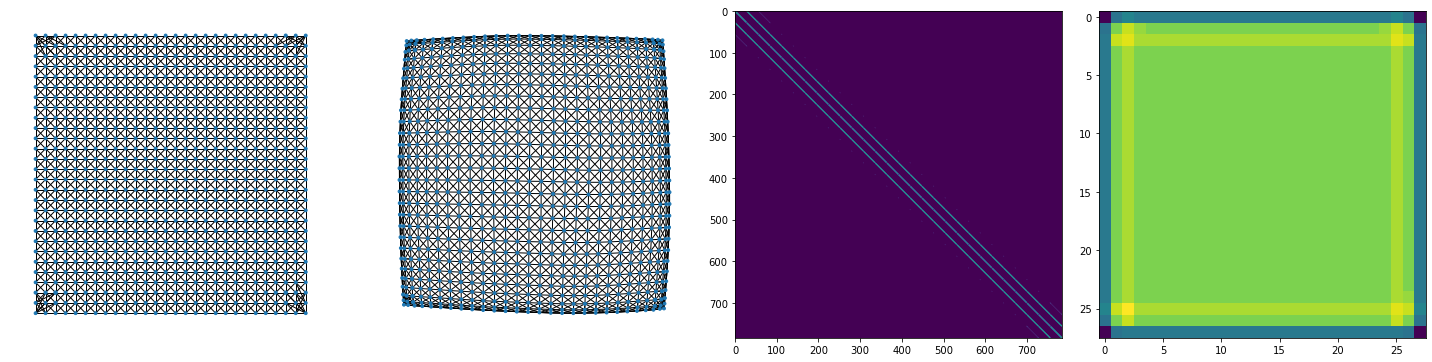

In [15]:
A = generate_graph(28, 8)
plt.imshow(A.todense())
fig, ax = plt.subplots(figsize=(8, 8))
ax = create_graph(A, ax=ax, size_factor=1)
ax = create_graph(A, ax=ax, size_factor=1, spring_layout=True)
fig, axes = plt.subplots(figsize=(20, 5), ncols=4)
axes[2].imshow(A.todense())
 
# degree matrix D
D = A.sum(axis=0).reshape(28, 28)
axes[3].imshow(D)
 
axes[0] = create_graph(A, ax=axes[0], size_factor=1)
axes[1] = create_graph(A, ax=axes[1], size_factor=1, spring_layout=True)
fig.tight_layout()

threshold = 0.25  # to reduce the noise for averaged signals
# threshold = 0.5
d_emotion_graphs = {}  # to collect feature graphs from each class


Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


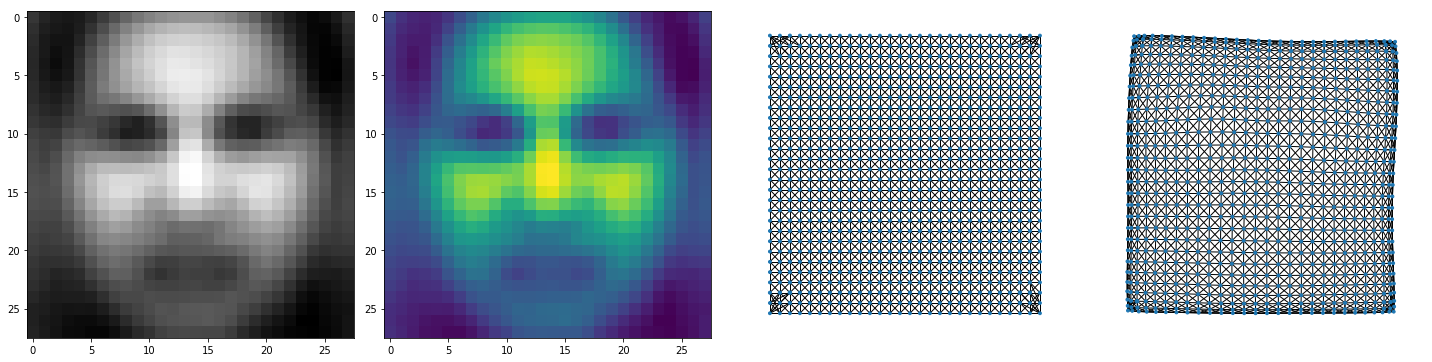

Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


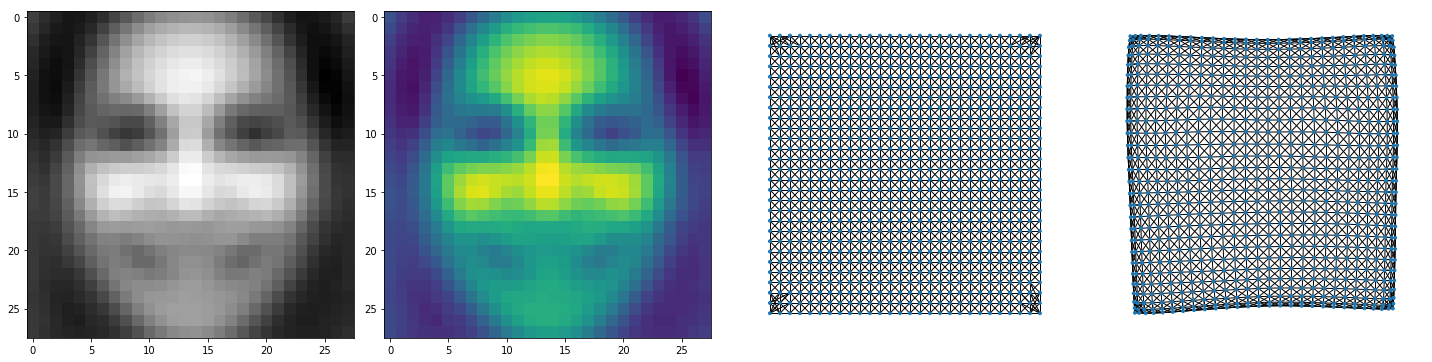

Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


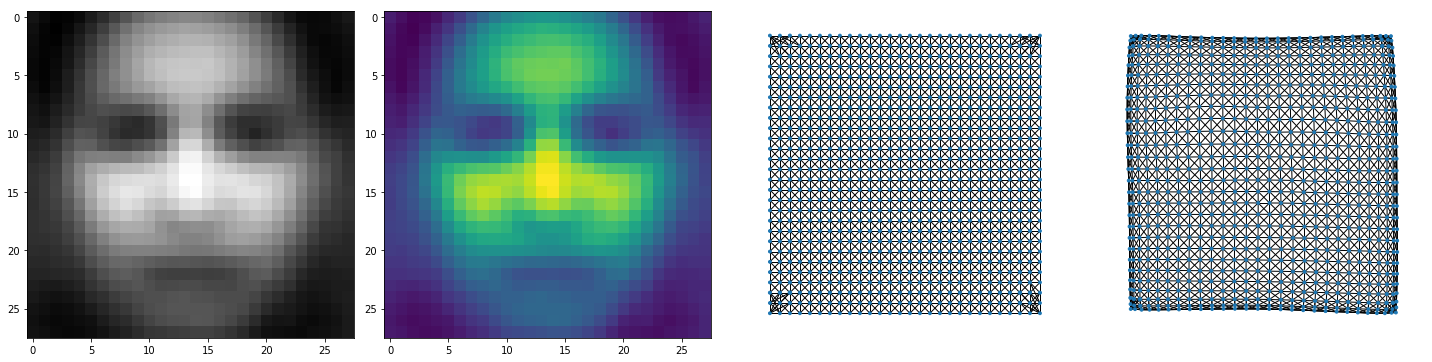

Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


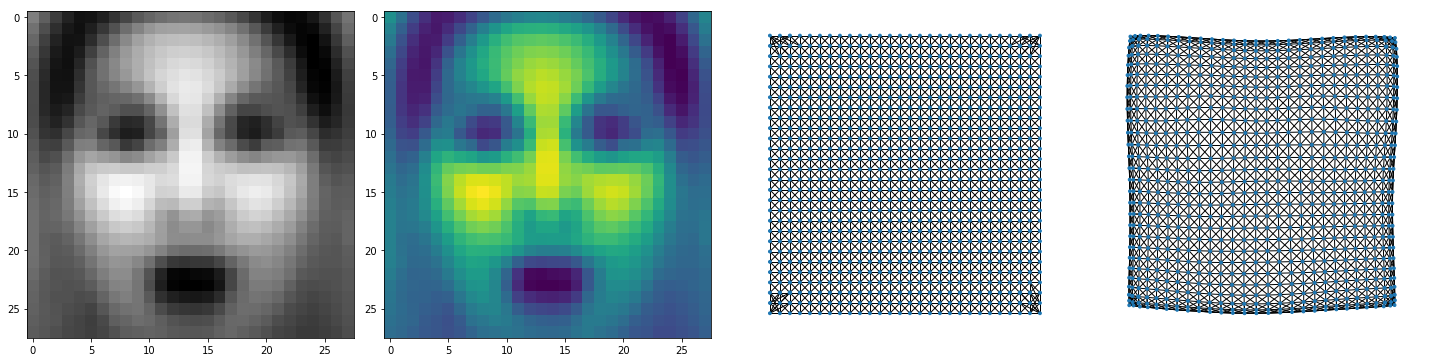

In [16]:
for i in range(num_labels):
    mask = y_train == i
    fig, axes = plt.subplots(figsize=(20, 5), ncols=4)
    x_train_i_avg = X_train[mask].mean(axis=0).flatten()
    axes[0].imshow(x_train_i_avg.reshape(28, 28),cmap='gray')
    # threshold the averages of pixels
    x_train_i_avg[x_train_i_avg < threshold] = 0
    axes[1].imshow(x_train_i_avg.reshape(28, 28))
    # a sparse diag matrix with the intensities values on the diagnoal
    A_diag_i = sp.diags(x_train_i_avg, dtype=np.float32).tolil()
    A_i = A.dot(A_diag_i)
    d_emotion_graphs[i] = A_i
    axes[2] = create_graph(A_i, ax=axes[2], size_factor=1)
    axes[3] = create_graph(A_i, ax=axes[3], size_factor=1, spring_layout=True)
    fig.tight_layout()
    plt.show()



In [17]:
# --------------graph_convolution_one_layer_model-----------
print("=========== -graph_convolution_one_layer_model- ============")
test_scores = []
model_full_grid = graph_convolution_one_layer_model(A)
model_full_grid.summary()
validation_data = (X_val, y_val)
model_full_grid.fit(X_train,
                    y_train,
                    batch_size=user_model_batch,
                    validation_data=validation_data,
                    epochs=epochs)
print('Evaluating model.')
eval_results = model_full_grid.evaluate(X_test,
                              y_test,
                              batch_size=user_model_batch)
print('loss:{}\n' 
      'acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'graph_convolution_one_layer_model',
    'accuracy': eval_results[1]
})


=========== -graph_convolution_one_layer_model- ============






Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784, 1)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (784, 784)           0                                            
__________________________________________________________________________________________________
graph_conv_1 (GraphConv)        (None, 784, 10)      20          input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)      

In [ ]:
# --------------graph_convolution_multi_layer_model-----------
print("=========== -graph_convolution_multi_layer_model- ============")
test_scores = []
model_full_grid = graph_convolution_network(A)
model_full_grid.summary()
validation_data = (X_val, y_val)
model_full_grid.fit(X_train,
                    y_train,
                    batch_size=user_model_batch,
                    validation_data=validation_data,
                    epochs=epochs)
print('Evaluating model.')
eval_results = model_full_grid.evaluate(X_test,
                              y_test,
                              batch_size=user_model_batch)
print('loss:{}\n' 
      'acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'graph_convolution_multi_layer_model',
    'accuracy': eval_results[1]
})

=========== -graph_convolution_multi_layer_model- ============

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784, 1)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (784, 784)           0                                            
__________________________________________________________________________________________________
graph_conv_2 (GraphConv)        (None, 784, 32)      64          input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
graph_conv_3 (GraphConv)    

In [ ]:
A0 = sp.csr_matrix(A.shape, dtype=np.float32)
print(A0.shape, A0.nnz)
model_no_graph = GCN_single_layer(A0)
model_no_graph.summary()
model_no_graph.fit(X_train,
                    y_train,
                    batch_size=user_model_batch,
                    validation_data=validation_data,
                    epochs=epochs)
print('Evaluating model.')
eval_results = model_no_graph.evaluate(X_test,
                              y_test,
                              batch_size=user_model_batch)
print('loss: {}\n'
      'acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'GCN graph',
    'accuracy': eval_results[1]
})


def fc_model(N=28 * 28, F=1,
             n_out=10,
             l2_reg=user_reguralization_rate,
             learning_rate=user_model_learning_rate):
    '''-connected model classification.
    '''
    X_in = Input(shape=(N, F))

    fc = Dense(10, activation='relu',
               kernel_regularizer=l2(l2_reg),
               use_bias=True)(Flatten()(X_in))

    output = Dense(n_out, activation='softmax')(fc)

    # Build model
    model = Model(inputs=X_in, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model_fc = fc_model()
model_fc.summary()
model_fc.fit(X_train,
                    y_train,
                    batch_size=user_model_batch,
                    validation_data=validation_data,
                    epochs=epochs)


In [ ]:
# Evaluate model
print('Evaluating model.')
eval_results = model_fc.evaluate(X_test,
                              y_test,
                              batch_size=user_model_batch)
print('Done.\n'
      'Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'connected model',
    'accuracy': eval_results[1]
})

In [ ]:
d_emotion_models = {}
for emotion in range(num_labels):
    model_i = GCN_single_layer(d_emotion_graphs[emotion])
    print(emotion, d_emotion_graphs[emotion].nnz)

    # Train model with emotion feature graph
    model_i.fit(X_train,
                        y_train,
                        batch_size=user_model_batch,
                        validation_data=validation_data,
                        epochs=epochs)
    
    d_emotion_models[emotion] = model_i

In [ ]:
for emotion, model_i in d_emotion_models.items():
    eval_results = model_i.evaluate(X_test,
                                  y_test,
                                  batch_size=user_model_batch)
    print('Emotion %s' % train_labels[emotion])
    print('Test loss: {}\n'
          'Test acc: {}'.format(*eval_results))
    
    test_scores.append({
        'model': 'GCN trimmed ',
        'emotion': emotion,
        'accuracy': eval_results[1]
    })    

In [ ]:
y_test_preds = model_no_graph.predict(X_test)
print(y_test_preds.shape)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
fig = plot_confusion_matrix(cm/cm.sum(axis=1))
fig.get_axes()[0].set_title('No graph');
for i in range(0,num_labels):
    print("Emotion mapping  {} : {} ".format(i,train_labels[i]))

In [ ]:
acc_df = {}
for model_name, model in d_emotion_models.items():
    
    y_test_preds = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
    
  
    acc_per_classes = np.diag(cm/cm.sum(axis=1))

    
    acc_df[model_name] = acc_per_classes

In [ ]:
d_emotion_corr_graphs = {}  


for i in range(num_labels):
    mask = y_train == i

    dist = metrics.pairwise_distances(X_train[mask].reshape(-1, 784).T, metric='cosine', n_jobs=-2)

    W = sp.coo_matrix(1 - dist, dtype=np.float32)

    # No self-connections.
    W.setdiag(0)

    # Non-directed graph.
    bigger = W.T > W
    W = W - W.multiply(bigger) + W.T.multiply(bigger)

    assert W.nnz % 2 == 0
    assert np.abs(W - W.T).mean() < 1e-10
    assert type(W) is sp.csr.csr_matrix

    fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

    x_train_i_avg = X_train[mask].mean(axis=0).flatten()
    axes[0].imshow(x_train_i_avg.reshape(28, 28))

    # thresholding
    W = W.multiply(W > 0.8)

    d_emotion_corr_graphs[i] = W

    axes[1] = create_graph(W, ax=axes[1], size_factor=1)

    axes[2] = create_graph(W, ax=axes[2], size_factor=1, spring_layout=True)
    fig.tight_layout()
    plt.show()


In [ ]:
fig, axes = plt.subplots(figsize=(20, 6), nrows=3, ncols=num_labels)

for i in range(num_labels):
    mask = y_train == i
    x_train_i_avg = X_train[mask].mean(axis=0).flatten()
    axes[0, i].imshow(x_train_i_avg.reshape(28, 28))
    axes[0, i].axis('off')
    
    axes[1, i] = create_graph(d_emotion_graphs[i], ax=axes[1, i], size_factor=0.2)
    axes[2, i] = create_graph(d_emotion_corr_graphs[i], ax=axes[2, i], size_factor=0.2)
    
    
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)



In [ ]:
def plot_confusion_matrix(cm, classes=list(range(num_labels))):
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(cm_df,
                     fmt='.3f',
                     annot=True, cmap='Reds', ax=ax)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.tight_layout()
    return fig
y_test_preds = model_full_grid.predict(X_test)
print(y_test_preds.shape)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
fig = plot_confusion_matrix(cm/cm.sum(axis=1))
fig.get_axes()[0].set_title('GCN');
for i in range(0,num_labels):
    print("Emotion mapping  {} : {} ".format(i,train_labels[i])) 

  

In [ ]:
y_test_preds = model_full_grid.predict(X_test)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
acc_per_class_full_model = np.diag(cm/cm.sum(axis=1))
acc_per_class_full_model
for i in range(0,num_labels):
    print("Emotion efficency : {} :{} ".format(train_labels[i],acc_per_class_full_model[i]))